In [1]:
# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator

import multiprocessing

import yaml # pyyaml library for reading the parameters.yml file

import os

### Setup params for all runs

Read the parameters file

In [3]:
PARAMETERS_FILENAME = "default.yml"
with open(os.path.join("..","model_parameters", PARAMETERS_FILENAME)) as f:
    parameters = yaml.load(f, Loader=yaml.SafeLoader)
    
sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]  # Parameters for the disease model (r)

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [5]:
current_risk_beta = disease_params['current_risk_beta']

# The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    proportion_asymptomatic=proportion_asymptomatic
)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. To run with new population data just re-run `main.py --opencl` without the `--use-cache` option, so that it regenerates a new snapshot file and writes it to this location.

In [10]:
opencl_dir = "../microsim/opencl"
snapshot_filepath = os.path.join(opencl_dir, "snapshots", "cache.npz")

### Run OpenCL simulation for multiple repetitions

In [12]:
import _run_opencl_model

iterations = 100
repetitions = 4
summaries = []
final_results = []
num_seed_days = 10
use_gpu=False

try:
    with multiprocessing.Pool(processes=int(os.cpu_count())) as pool:

        results = pool.map(_run_opencl_model.f, XXXX)
        summaries = [x[0] for x in results]
        final_results = [x[1] for x in results]
finally:  # Make sure they get closed (shouldn't be necessary)
    pool.close()


Running simulation 1 out of 4


Running simulation: 100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


Final counts:
	Susceptible: 633026
	Exposed: 1015
	Presymptomatic: 899
	Asymptomatic: 3376
	Symptomatic: 5049
	Recovered: 51771
	Dead: 173
Running simulation 2 out of 4


Running simulation: 100%|██████████| 100/100 [00:08<00:00, 11.11it/s]


Final counts:
	Susceptible: 628135
	Exposed: 837
	Presymptomatic: 713
	Asymptomatic: 2789
	Symptomatic: 4305
	Recovered: 58328
	Dead: 202
Running simulation 3 out of 4


Running simulation: 100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


Final counts:
	Susceptible: 631534
	Exposed: 898
	Presymptomatic: 778
	Asymptomatic: 3008
	Symptomatic: 4639
	Recovered: 54247
	Dead: 205
Running simulation 4 out of 4


Running simulation: 100%|██████████| 100/100 [00:09<00:00, 10.95it/s]

Final counts:
	Susceptible: 631063
	Exposed: 911
	Presymptomatic: 777
	Asymptomatic: 3064
	Symptomatic: 4409
	Recovered: 54870
	Dead: 215


### Plot output summary data

In [13]:
import matplotlib.pyplot as plt
from microsim.opencl.ramp.disease_statuses import DiseaseStatus


def plot_summary_counts(summary, repetition_num):
    x = range(iterations)
    
    for disease_status in DiseaseStatus:
        plt.plot(x, summary.total_counts[disease_status.value], label=disease_status.name)
    
    plt.title(f"Results - repetition {repetition_num}")
    plt.legend() 
    plt.show()
    

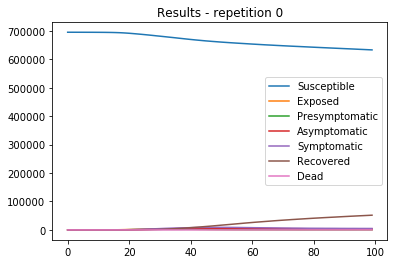

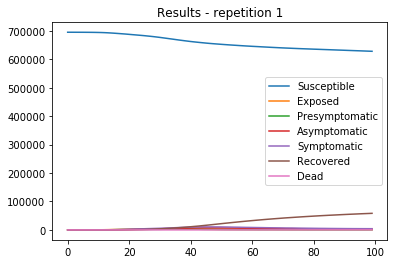

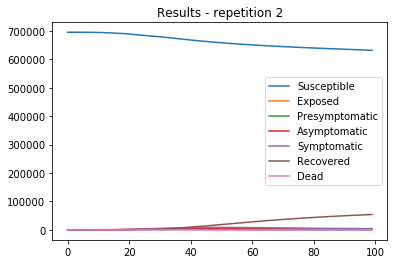

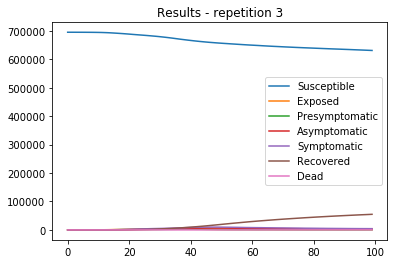

In [14]:
for i, summary in enumerate(summaries):
    plot_summary_counts(summary, i)

### Plot disease statuses by age

In [15]:
def plot_disease_status_by_age(summary, disease_status):
    age_thresholds = summary.age_thresholds
    age_counts = summary.age_counts[disease_status]
    x = range(iterations)
    
    lower_age_bound = 0
    for (i, age_threshold) in enumerate(age_thresholds):
        plt.plot(x, age_counts[i], label=f"{lower_age_bound} - {age_threshold}")
        lower_age_bound = age_threshold
    
    plt.title(f"Num {disease_status} people by age group")
    plt.legend() 
    plt.show()
    

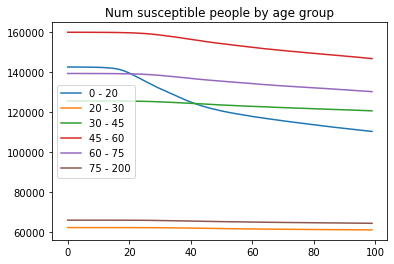

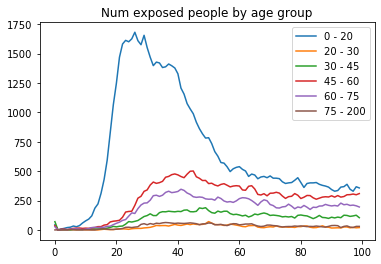

In [16]:
plot_disease_status_by_age(summaries[0], "susceptible")
plot_disease_status_by_age(summaries[0], "exposed")

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


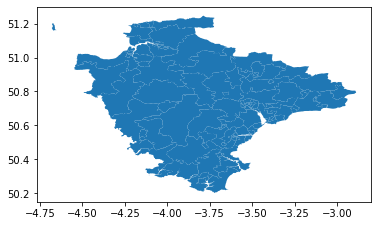

In [17]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [18]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

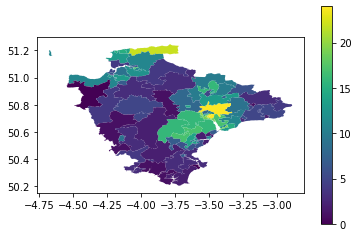

In [19]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, summaries[0], disease_status, 99)